In [96]:
%reset -f

# Importing data

Data has been stored in local using aws cli. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from pathlib import Path
from IPython.display import Markdown, display

DATA_PATH = "/home/alejandro/Zrive"

abandoned_carts_df = pd.read_parquet(Path(DATA_PATH, "abandoned_carts.parquet"))
inventory_df = pd.read_parquet(Path(DATA_PATH, "inventory.parquet"))
orders_df = pd.read_parquet(Path(DATA_PATH, "orders.parquet"))
regulars_df = pd.read_parquet(Path(DATA_PATH, "regulars.parquet"))
users_df = pd.read_parquet(Path(DATA_PATH, "users.parquet"))

feature_frame = pd.read_csv(Path(DATA_PATH, "feature_frame.csv"))


def printmd(string):
    display(Markdown(string))

# Part 1: Understanding the problem space

The data is partitioned over multiple dataset and comes from a groceries ecommerce
platform selling products directly to consumers (think of it as an online
supermarket):

**orders.parquet**: An order history of customers. Each row is an order and the
item_ids for the order are stored as a list in the item_ids column

**regulars.parquet**: Users are allowed to specify items that they wish to buy
regularly. This data gives the items each user has asked to get regularly, along
with when they input that information.

**abandoned_cart.parquet**: If a user has added items to their basket but not
bought them, we capture that information. Items that were abandoned are stored
as a list in item_ids.

**inventory.parquet**: Some information about each item_id

**users.parquet**: Information about users.

In [5]:
# Quick check on each dataset to understand their structure and identify potential issues
datasets = {
    "Abandoned Carts": abandoned_carts_df,
    "Inventory": inventory_df,
    "Orders": orders_df,
    "Regulars": regulars_df,
    "Users": users_df,
}

# Displaying the first few rows of each dataset and their info to identify potential issues
for name, df in datasets.items():
    printmd(f"# Dataset: {name}")
    display(df.head())
    df.info()
    print("\nMising values(NAs):")
    display(df.isna().sum())

# Dataset: Abandoned Carts

,id,user_id,created_at,variant_id
0,12858560217220,5c4e5953f13ddc3bc9659a3453356155e5efe4739d7a2b...,2020-05-20 13:53:24,"[33826459287684, 33826457616516, 3366719212762..."
13,20352449839236,9d6187545c005d39e44d0456d87790db18611d7c7379bd...,2021-06-27 05:24:13,"[34415988179076, 34037940158596, 3450282236326..."
45,20478401413252,e83fb0273d70c37a2968fee107113698fd4f389c442c0b...,2021-07-18 08:23:49,"[34543001337988, 34037939372164, 3411360609088..."
50,20481783103620,10c42e10e530284b7c7c50f3a23a98726d5747b8128084...,2021-07-18 21:29:36,"[33667268116612, 34037940224132, 3443605520397..."
52,20485321687172,d9989439524b3f6fc4f41686d043f315fb408b954d6153...,2021-07-19 12:17:05,"[33667268083844, 34284950454404, 33973246886020]"


<class 'pandas.core.frame.DataFrame'>
Index: 5457 entries, 0 to 70050
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          5457 non-null   int64         
 1   user_id     5457 non-null   object        
 2   created_at  5457 non-null   datetime64[us]
 3   variant_id  5457 non-null   object        
dtypes: datetime64[us](1), int64(1), object(2)
memory usage: 213.2+ KB

Mising values(NAs):


id            0
user_id       0
created_at    0
variant_id    0
dtype: int64

# Dataset: Inventory

,variant_id,price,compare_at_price,vendor,product_type,tags
0,39587297165444,3.09,3.15,heinz,condiments-dressings,"[table-sauces, vegan]"
1,34370361229444,4.99,5.50,whogivesacrap,toilet-roll-kitchen-roll-tissue,"[b-corp, eco, toilet-rolls]"
2,34284951863428,3.69,3.99,plenty,toilet-roll-kitchen-roll-tissue,[kitchen-roll]
3,33667283583108,1.79,1.99,thecheekypanda,toilet-roll-kitchen-roll-tissue,"[b-corp, cruelty-free, eco, tissue, vegan]"
4,33803537973380,1.99,2.09,colgate,dental,[dental-accessories]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1733 entries, 0 to 1732
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   variant_id        1733 non-null   int64  
 1   price             1733 non-null   float64
 2   compare_at_price  1733 non-null   float64
 3   vendor            1733 non-null   object 
 4   product_type      1733 non-null   object 
 5   tags              1733 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 81.4+ KB

Mising values(NAs):


variant_id          0
price               0
compare_at_price    0
vendor              0
product_type        0
tags                0
dtype: int64

# Dataset: Orders

,id,user_id,created_at,order_date,user_order_seq,ordered_items
10,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,"[33618849693828, 33618860179588, 3361887404045..."
20,2204707520644,bf591c887c46d5d3513142b6a855dd7ffb9cc00697f6f5...,2020-04-30 17:39:00,2020-04-30,1,"[33618835243140, 33618835964036, 3361886244058..."
21,2204838822020,329f08c66abb51f8c0b8a9526670da2d94c0c6eef06700...,2020-04-30 18:12:30,2020-04-30,1,"[33618891145348, 33618893570180, 3361889766618..."
34,2208967852164,f6451fce7b1c58d0effbe37fcb4e67b718193562766470...,2020-05-01 19:44:11,2020-05-01,1,"[33618830196868, 33618846580868, 3361891234624..."
49,2215889436804,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,2020-05-03 21:56:14,2020-05-03,1,"[33667166699652, 33667166699652, 3366717122163..."


<class 'pandas.core.frame.DataFrame'>
Index: 8773 entries, 10 to 64538
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              8773 non-null   int64         
 1   user_id         8773 non-null   object        
 2   created_at      8773 non-null   datetime64[us]
 3   order_date      8773 non-null   datetime64[us]
 4   user_order_seq  8773 non-null   int64         
 5   ordered_items   8773 non-null   object        
dtypes: datetime64[us](2), int64(2), object(2)
memory usage: 479.8+ KB

Mising values(NAs):


id                0
user_id           0
created_at        0
order_date        0
user_order_seq    0
ordered_items     0
dtype: int64

# Dataset: Regulars

,user_id,variant_id,created_at
3,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33618848088196,2020-04-30 15:07:03
11,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667178659972,2020-05-05 23:34:35
18,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33619009208452,2020-04-30 15:07:03
46,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667305373828,2020-05-05 23:34:35
47,4594e99557113d5a1c5b59bf31b8704aafe5c7bd180b32...,33667247341700,2020-05-06 14:42:11


<class 'pandas.core.frame.DataFrame'>
Index: 18105 entries, 3 to 37720
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     18105 non-null  object        
 1   variant_id  18105 non-null  int64         
 2   created_at  18105 non-null  datetime64[us]
dtypes: datetime64[us](1), int64(1), object(1)
memory usage: 565.8+ KB

Mising values(NAs):


user_id       0
variant_id    0
created_at    0
dtype: int64

# Dataset: Users

,user_id,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,count_people,count_adults,count_children,count_babies,count_pets
2160,0e823a42e107461379e5b5613b7aa00537a72e1b0eaa7a...,Top Up,UKH,2021-05-08 13:33:49,2021-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN
1123,15768ced9bed648f745a7aa566a8895f7a73b9a47c1d4f...,Top Up,UKJ,2021-11-17 16:30:20,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN
1958,33e0cb6eacea0775e34adbaa2c1dec16b9d6484e6b9324...,Top Up,UKD,2022-03-09 23:12:25,2022-03-01 00:00:00,NaN,NaN,NaN,NaN,NaN
675,57ca7591dc79825df0cecc4836a58e6062454555c86c35...,Top Up,UKI,2021-04-23 16:29:02,2021-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN
4694,085d8e598139ce6fc9f75d9de97960fa9e1457b409ec00...,Top Up,UKJ,2021-11-02 13:50:06,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Index: 4983 entries, 2160 to 3360
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                4983 non-null   object 
 1   user_segment           4983 non-null   object 
 2   user_nuts1             4932 non-null   object 
 3   first_ordered_at       4983 non-null   object 
 4   customer_cohort_month  4983 non-null   object 
 5   count_people           325 non-null    float64
 6   count_adults           325 non-null    float64
 7   count_children         325 non-null    float64
 8   count_babies           325 non-null    float64
 9   count_pets             325 non-null    float64
dtypes: float64(5), object(5)
memory usage: 428.2+ KB

Mising values(NAs):


user_id                     0
user_segment                0
user_nuts1                 51
first_ordered_at            0
customer_cohort_month       0
count_people             4658
count_adults             4658
count_children           4658
count_babies             4658
count_pets               4658
dtype: int64

## Check Orders 

With the orders dataframe, we could try to identify the purchasing patterns of customers. Both, the number of orders per user and the number of items per order are important metrics to understand the purchasing patterns of customers. 



Let's first check the frequency of orders per user.

count    4983.000000
mean        1.760586
std         1.936537
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        25.000000
Name: order_count, dtype: float64

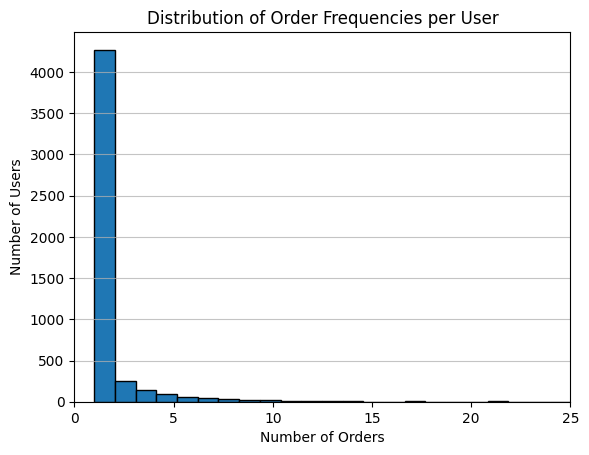

In [6]:
orders_frequency = (
    orders_df["user_id"]
    .value_counts()
    .reset_index()
    .rename(columns={"count": "order_count"})
)
display(orders_frequency["order_count"].describe())
plt.hist(
    orders_frequency["order_count"],
    bins=len(orders_frequency["order_count"].unique()),
    edgecolor="k",
)
plt.title("Distribution of Order Frequencies per User")
plt.xlabel("Number of Orders")
plt.ylabel("Number of Users")
plt.xlim(min(orders_frequency["order_count"] - 1), max(orders_frequency["order_count"]))
plt.grid(axis="y", alpha=0.75)
plt.show()

Most of users just make 1 order, which indicates that the platform has a large base of "one time" users. Let's now check the distribution of order sizes.

count    8773.000000
mean       12.305711
std         6.839507
min         1.000000
25%         8.000000
50%        11.000000
75%        15.000000
max       114.000000
Name: order_size, dtype: float64

Most common order size: 10

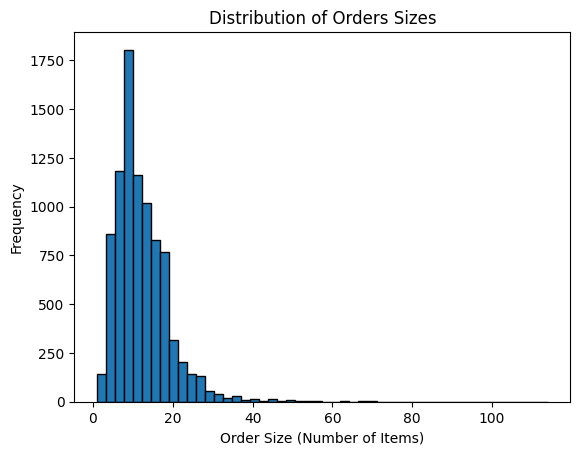

In [7]:
# Calculate order size as the length of the ordered_items list for each order
orders_df["order_size"] = orders_df["ordered_items"].apply(len)
# Analyze the distribution of order sizes
order_size_distribution = orders_df["order_size"].describe()
display(order_size_distribution)
printmd(f"Most common order size: {orders_df['order_size'].mode()[0]}")
plt.hist(orders_df["order_size"], bins=50, edgecolor="k")
plt.title("Distribution of Orders Sizes")
plt.xlabel("Order Size (Number of Items)")
plt.ylabel("Frequency")
plt.show()

As we can see, most orders have 10 items, but there are users who make orders with lots of items creating a long right tail. 
Let's now check the most ordered items. 
As each item has a unique id, we can't know what each item is. However, we can see that all items fall into a specific category, thus ,we can show the most ordered items by mapping its id to its category.

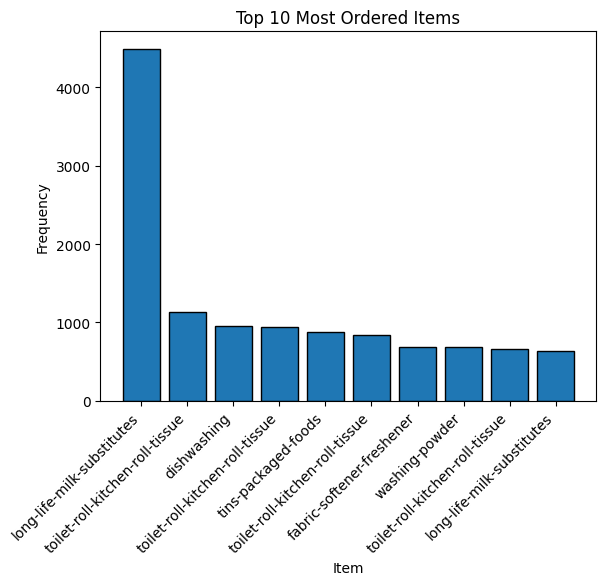

In [39]:
item_frequencies = (
    orders_df.explode("ordered_items")["ordered_items"]
    .value_counts()
    .reset_index()
    .rename(columns={"ordered_items": "variant_id", "count": "item_count"})
)

# merge with inventory to get category information
common_items = pd.merge(item_frequencies, inventory_df, on="variant_id", how="inner")

# plot the top 10 most ordered items
plt.bar(
    common_items["variant_id"][:10].astype(str),
    common_items["item_count"][:10],
    edgecolor="k",
)
plt.title("Top 10 Most Ordered Items")
plt.xlabel("Item")
plt.ylabel("Frequency")
plt.xticks(
    ticks=range(0, 10),
    labels=common_items["product_type"][:10],
    rotation=45,
    ha="right",
)
plt.show()

There is a catch here, as we don't have the category of each item, when we merged the datasets, item_frequencies(n=2117) and inventory(n=1733), we lost some items. This is because the inventory dataset has less items than the orders dataset.

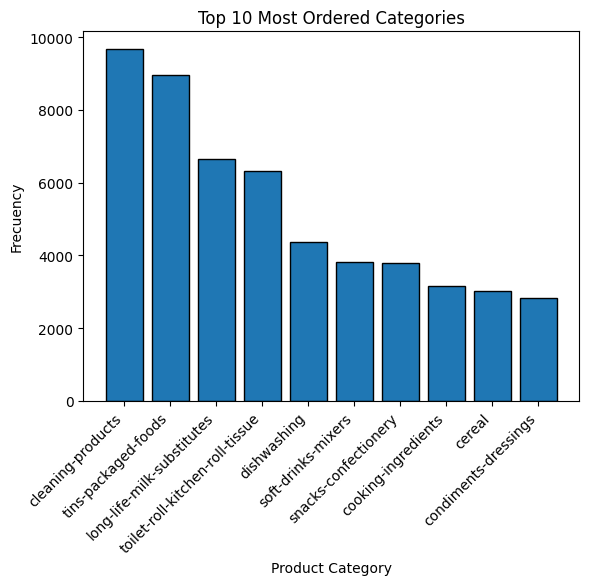

In [11]:
# Determine the most commonly ordered categories
common_categories = (
    common_items.groupby("product_type")["item_count"]
    .sum()
    .reset_index()
    .sort_values("item_count", ascending=False)
)

plt.bar(
    x=common_categories["product_type"][:10],
    height=common_categories["item_count"][:10],
    edgecolor="k",
)
plt.title("Top 10 Most Ordered Categories")
plt.xlabel("Product Category")
plt.ylabel("Frecuency")
plt.xticks(rotation=45, ha="right")
plt.show()

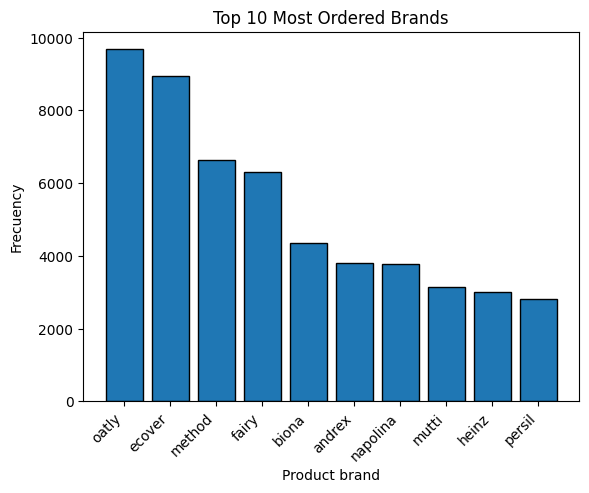

In [89]:
# Top 10 most ordered brands
common_brands = (
    common_items.groupby("vendor")["item_count"]
    .sum()
    .reset_index()
    .sort_values("item_count", ascending=False)
)

plt.bar(
    x=common_brands["vendor"][:10],
    height=common_categories["item_count"][:10],
    edgecolor="k",
)
plt.title("Top 10 Most Ordered Brands")
plt.xlabel("Product brand")
plt.ylabel("Frecuency")
plt.xticks(rotation=45, ha="right")
plt.show()

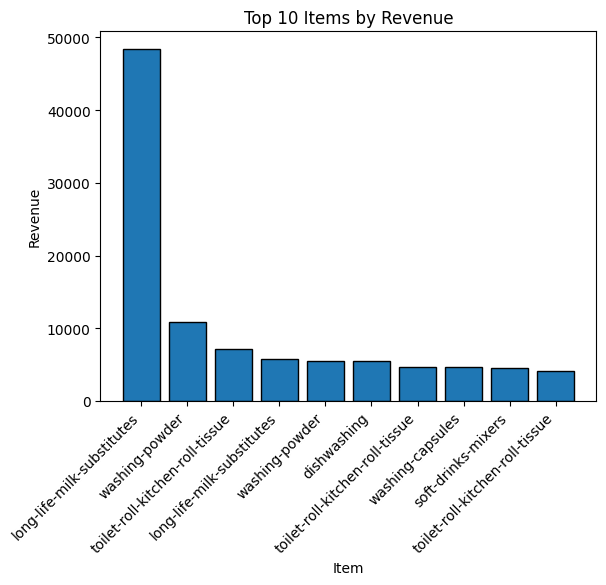

In [90]:
# Determine the items and categories which bring the most revenue
# Calculate the revenue for each item by multiplying the price of each item by the quantity ordered
common_items["revenue"] = common_items["item_count"] * common_items["price"]
common_items = common_items.sort_values("revenue", ascending=False)

plt.bar(
    common_items["variant_id"][:10].astype(str),
    common_items["revenue"][:10],
    edgecolor="k",
)
plt.title("Top 10 Items by Revenue")
plt.xlabel("Item")
plt.ylabel("Revenue")
plt.xticks(
    ticks=range(0, 10),
    labels=common_items["product_type"][:10],
    rotation=45,
    ha="right",
)
plt.show()

As we can see, the product which produces the most revenue by far, is part of the milk category. This might indicate that the platform relies too much in selling this kind of milk-related product. To check this, let's compare the revenue of the top ten products against the revenue of the rest of the products.

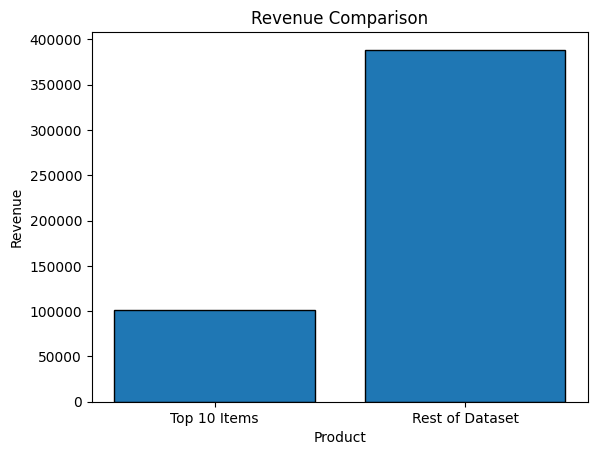

Percentage of revenue from the top 10 items: 20.68%

Percentage of revenue from the rest of the dataset: 79.32%

Percentage of revenue from the top product: 9.88%

In [16]:
# Calculate the total revenue of the rest of the dataset
rest_revenue = common_items["revenue"][10:].sum()

# Create a new dataframe to hold the data for the bar plot
revenue_data = pd.DataFrame(
    {
        "Product": ["Top 10 Items", "Rest of Dataset"],
        "Revenue": [common_items["revenue"][:10].sum(), rest_revenue],
    }
)

# Plot the bar chart
plt.bar(revenue_data["Product"], revenue_data["Revenue"], edgecolor="k")
plt.title("Revenue Comparison")
plt.xlabel("Product")
plt.ylabel("Revenue")
plt.show()

# Calculate percentage of revenue from the top 10 items
top_10_revenue = common_items["revenue"][:10].sum()
total_revenue = common_items["revenue"].sum()
top_10_revenue_percentage = top_10_revenue / total_revenue * 100
printmd(
    f"Percentage of revenue from the top 10 items: {top_10_revenue_percentage:.2f}%"
)
# Calculate percentage of revenue from the rest of the dataset
rest_revenue = common_items["revenue"][10:].sum()
rest_revenue_percentage = rest_revenue / total_revenue * 100
printmd(
    f"Percentage of revenue from the rest of the dataset: {rest_revenue_percentage:.2f}%"
)
# Calculate percentage of revenue from the top product
top_product_revenue = common_items["revenue"][0]
top_product_revenue_percentage = top_product_revenue / total_revenue * 100
printmd(
    f"Percentage of revenue from the top product: {top_product_revenue_percentage:.2f}%"
)

The platform's product portfolio doesn't appear to be well balanced in terms of its item revenues, with the top ten products accounting for 20% of the total revenue, while the other 1467 products account for the remaining 80% . Moreover, the top product represents 10% of the total revenue, which is a lot for a single product. Let's now check revenue by general categories.

/tmp/ipykernel_4591/1866416911.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(category_revenue['product_type'],rotation=45, ha='right')
/tmp/ipykernel_4591/1866416911.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(category_revenue['product_type'][:10],rotation=45, ha='right')


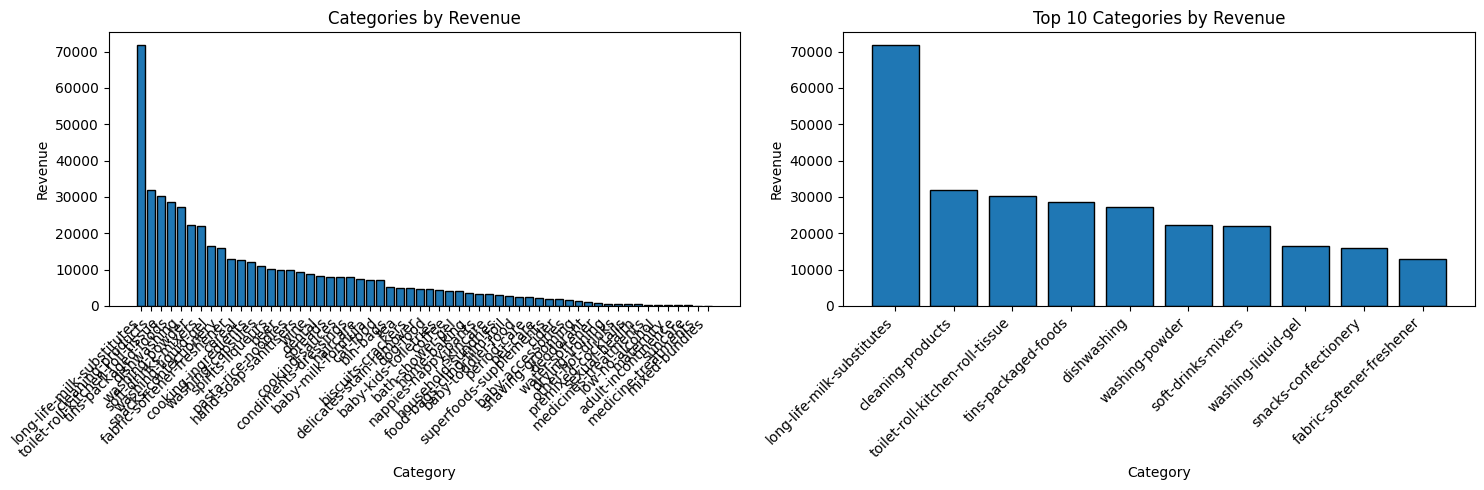

In [17]:
category_revenue = (
    common_items.groupby("product_type")["revenue"]
    .sum()
    .reset_index()
    .sort_values("revenue", ascending=False)
)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].bar(
    x=category_revenue["product_type"],
    height=category_revenue["revenue"],
    edgecolor="k",
)
ax[0].set_title("Categories by Revenue")
ax[0].set_xlabel("Category")
ax[0].set_ylabel("Revenue")
ax[0].set_xticks(range(0, len(category_revenue)))
ax[0].set_xticklabels(category_revenue["product_type"], rotation=45, ha="right")


ax[1].bar(
    x=category_revenue["product_type"][:10],
    height=category_revenue["revenue"][:10],
    edgecolor="k",
)
ax[1].set_title("Top 10 Categories by Revenue")
ax[1].set_xlabel("Category")
ax[1].set_ylabel("Revenue")
ax[1].set_xticks(range(0, 10))
ax[1].set_xticklabels(category_revenue["product_type"][:10], rotation=45, ha="right")

plt.tight_layout()
plt.show()

Key Insights:

- User Behavior: Most users make only one order, indicating a large base of one-time users. Strategies could be developed to encourage repeat purchases.

- Order Size: Most orders contain around 10 items, but there is a long tail of orders with many items. This suggests a diverse range of customer shopping behaviors.

- Most Ordered Items: The most ordered items fall into categories like milk substitutes, toilet & kitchen roll tissue, dishwashing products, and fabric softeners. These are everyday household items, suggesting that users are using the platform for their regular grocery shopping.

- Most Ordered Brands: 4 out 5 of the most ordered brands are ecofriendly/organic/vegan brands, which suggests that the platform's user base may be environmentally conscious.

- Revenue Concentration: The top 10 items account for over 20% of total revenue, and the top product alone accounts for nearly 10%. This indicates a high concentration of revenue in a small number of products.

- Product Portfolio Balance: The product portfolio may not be well balanced, with a small number of products accounting for a large proportion of revenue. Diversifying the product portfolio could help reduce risk and increase potential for growth.

- Category Revenue: The milk category generates the most revenue, suggesting that dairy products are a key area for the platform. However, reliance on a single category could pose a risk if demand changes or supply issues arise.

- These insights can help inform strategies for product assortment, marketing, and customer retention.



## Check Users

Let's know try to combine the regulars dataframe with the users dataframe, to understand better the consumers behavior.

In [41]:
# Calculate number of regulars by user
regulars_by_user = (
    regulars_df.groupby("user_id")["variant_id"]
    .nunique()
    .reset_index()
    .rename(columns={"variant_id": "regulars_count"})
)
# Merge with users to get user information
users = pd.merge(users_df, regulars_by_user, on="user_id", how="left").fillna(
    {"regulars_count": 0}
)
users.describe()

,count_people,count_adults,count_children,count_babies,count_pets,regulars_count
count,325.000000,325.000000,325.000000,325.000000,325.000000,4983.000000
mean,2.787692,2.003077,0.707692,0.076923,0.636923,2.481437
std,1.365753,0.869577,1.026246,0.289086,0.995603,8.890588
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,2.000000,1.000000,0.000000,1.000000,1.000000
max,8.000000,7.000000,6.000000,2.000000,6.000000,320.000000


Most people don't have a regular list, which is expected, as it's most likely voluntary info. Let's check the number of regulars by user_segment

<Axes: ylabel='count'>

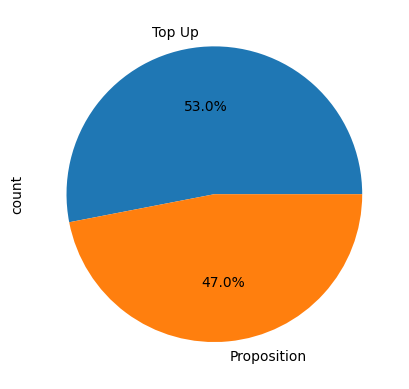

In [61]:
# distribution of user_segment values
users["user_segment"].value_counts().plot.pie(y="user_segment", autopct="%1.1f%%")

<Axes: ylabel='regulars_count'>

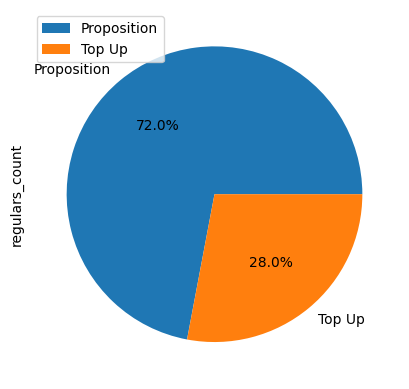

In [54]:
# Distribution by user_segment of the number of regulars
users.groupby("user_segment").sum().plot.pie(y="regulars_count", autopct="%1.1f%%")

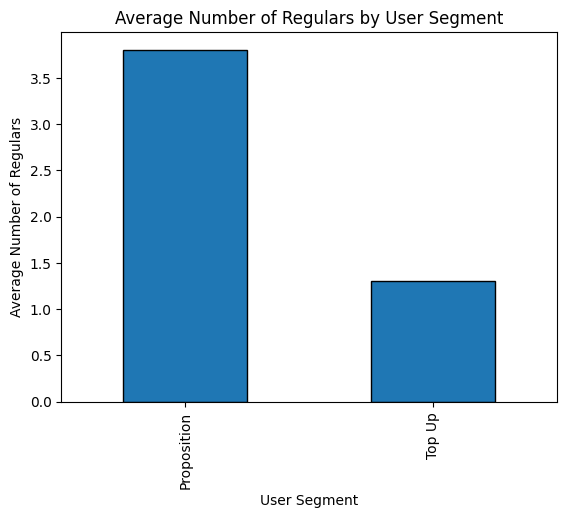

In [46]:
# Check the average number of regulars_count by user segment
users.groupby("user_segment")["regulars_count"].mean().plot.bar(edgecolor="k")
plt.title("Average Number of Regulars by User Segment")
plt.xlabel("User Segment")
plt.ylabel("Average Number of Regulars")
plt.show()

In [85]:
(users["count_people"] > 1).sum() / len(users["count_people"].dropna())

0.8184615384615385

<Axes: xlabel='user_nuts1'>

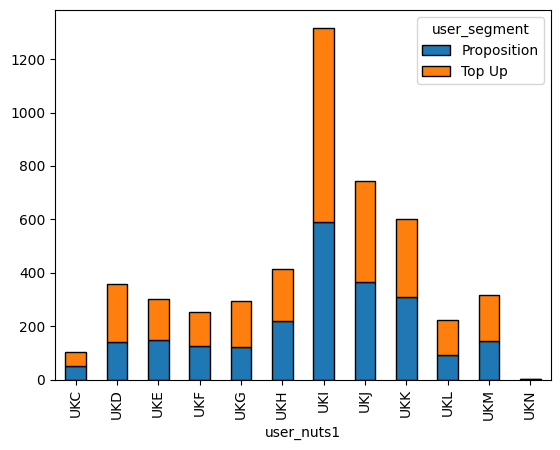

In [67]:
pd.crosstab(users["user_nuts1"], users["user_segment"]).plot.bar(
    stacked=True, edgecolor="k"
)

Insights:
- Most users don't have a regulars items, which is expected, as it's most likely voluntary info.
- The Users segments distribution is fairly similar: Top Up (53%), Proposition (47%)
- Users in the "Proposition" segment are more likely to have a regular list, which is expected, as they are more likely to be frequent users of the platform.
- From the users who have a regulars items, The proposition segment has the highest average number of regulars items (3.5), and the "Top Up" segment has an average of 1.5 regulars items.
- Most households who answered the survey live in a family(80%) while the rest live alone(20%).
- Most users come from Greater London (UKI), followed up by the South East (UKJ) and the South West (UKI). Which indicates that the platform is more popular in the south of the UK. The low number of users from the North West (UKD) could indicate that the platform is not as popular in the north of the UK considering it's the third most populous region in the UK.

## Check regulars

In [18]:
regulars = regulars_df.merge(inventory_df, on="variant_id", how="inner")

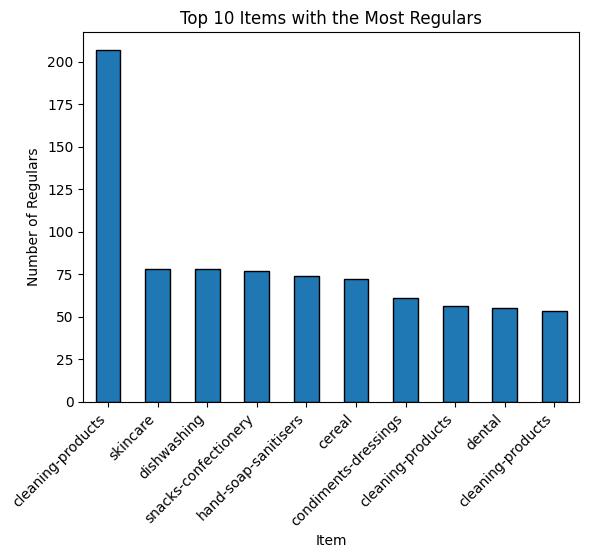

In [27]:
# Top 10 items with the most regulars
regulars.groupby("variant_id")["user_id"].nunique().sort_values(ascending=False).head(
    10
).plot.bar(edgecolor="k")
plt.title("Top 10 Items with the Most Regulars")
plt.xlabel("Item")
plt.ylabel("Number of Regulars")
plt.xticks(
    ticks=range(0, 10), labels=regulars["product_type"][:10], rotation=45, ha="right"
)
plt.show()

Curious, the most regular items don't match the most ordered item's categories nor the most ordered categories.

<Axes: xlabel='price', ylabel='Density'>

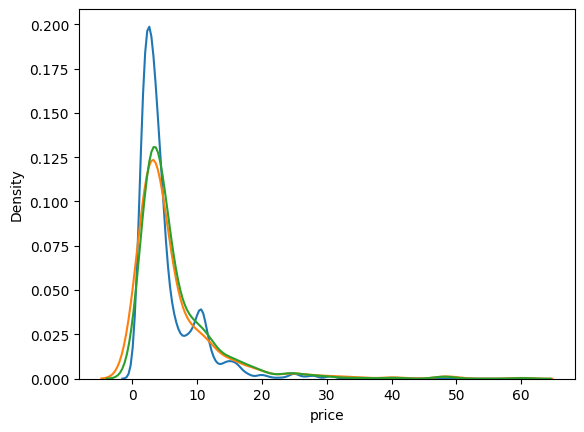

In [24]:
sns.kdeplot(regulars["price"], label="regular_price")
sns.kdeplot(inventory_df["price"], label="inventory_price")
sns.kdeplot(common_items["price"], label="common_items_price")

In [82]:
orders = (
    (
        orders_df.explode("ordered_items")["ordered_items"]
        .value_counts(normalize=True)
        .reset_index()
        .rename(
            columns={"ordered_items": "variant_id", "proportion": "orders_prevalence"}
        )
        .merge(inventory_df, on="variant_id")
    )
    .groupby("product_type")["orders_prevalence"]
    .sum()
    .reset_index()
    .sort_values("orders_prevalence", ascending=False)
)
orders.head(10)

,product_type,orders_prevalence
12,cleaning-products,0.089627
51,tins-packaged-foods,0.082986
29,long-life-milk-substitutes,0.061478
52,toilet-roll-kitchen-roll-tissue,0.058486
20,dishwashing,0.040405
45,soft-drinks-mixers,0.035273
44,snacks-confectionery,0.035078
15,cooking-ingredients,0.029178
10,cereal,0.027918
14,condiments-dressings,0.026131


In [84]:
diff_prevalence = (
    inventory_df["product_type"]
    .value_counts(normalize=True)
    .rename("inventory_prevalence")
    .reset_index()
    .merge(
        regulars["product_type"]
        .value_counts(normalize=True)
        .rename("regulars_prevalence")
        .reset_index()
    )
    .merge(orders[["product_type", "orders_prevalence"]], how="left")
    .assign(inventory_rank=lambda x: x["inventory_prevalence"].rank(ascending=False))
    .assign(regulars_rank=lambda x: x["regulars_prevalence"].rank(ascending=False))
    .assign(orders_rank=lambda x: x["orders_prevalence"].rank(ascending=False))
)

In [87]:
diff_prevalence.sort_values("regulars_prevalence", ascending=False).head(15)

,product_type,inventory_prevalence,regulars_prevalence,orders_prevalence,inventory_rank,regulars_rank,orders_rank
0,cleaning-products,0.092325,0.124850,0.089627,1.0,1.0,1.0
1,tins-packaged-foods,0.072129,0.093255,0.082986,2.0,2.0,2.0
21,dishwashing,0.015580,0.055474,0.040405,22.0,3.0,5.0
31,toilet-roll-kitchen-roll-tissue,0.010387,0.053346,0.058486,32.5,4.0,4.0
3,cooking-ingredients,0.042123,0.052148,0.029178,4.0,5.0,8.0
2,snacks-confectionery,0.070398,0.043900,0.035078,3.0,6.0,7.0
25,long-life-milk-substitutes,0.013849,0.037648,0.061478,25.5,7.0,3.0
6,condiments-dressings,0.030006,0.034655,0.026131,7.0,8.0,10.0
10,soft-drinks-mixers,0.027698,0.032061,0.035273,11.0,9.0,6.0
7,cereal,0.029429,0.031329,0.027918,8.0,10.0,9.0


Insights:
- Regulars product's rank categories are fairly similar to the most ordered product's categories. However, there are some major differences with the inventory product's rank categories. Diswashing, toilet & kitchen roll tissue, and milk substitutes products may be lacking. In any case, the stock level of each product is unknown, so no conclusions can be drawn.

# Part 2: EDA

In [101]:
display(feature_frame.head())
feature_frame.info()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [129]:
info_columns = ["variant_id", "order_id", "user_id", "created_at", "order_date"]
target = "outcome"
features_cols = [
    col for col in feature_frame.columns if col not in info_columns and col != target
]
categorical_cols = ["product_type", "vendor"]
binary_cols = ["ordered_before", "abandoned_before", "active_snoozed", "set_as_regular"]
numerical_cols = [
    col
    for col in features_cols
    if col not in categorical_cols and col not in binary_cols
]

print(f"Number of categorical variables : {len(categorical_cols)}")
print(f"Number of binary variables : {len(binary_cols)}")
print(f"Number of numerical variables : {len(numerical_cols)}")
print(f"Number of info variables : {len(info_columns)}")

Number of categorical variables : 2
Number of binary variables : 4
Number of numerical variables : 15
Number of info variables : 5


In [114]:
feature_frame[target].value_counts()
for col in binary_cols:
    print(f"Value counts for {col}: {feature_frame[col].value_counts().to_dict()}")
    print(
        f"Mean outcome by {col} value : {feature_frame.groupby(col)[target].mean().to_dict()}"
    )
    print("\n")

Value counts for ordered_before: {0.0: 2819658, 1.0: 60891}
Mean outcome by ordered_before value : {0.0: 0.008223337723936732, 1.0: 0.1649669080816541}


Value counts for abandoned_before: {0.0: 2878794, 1.0: 1755}
Mean outcome by abandoned_before value : {0.0: 0.011106039542947498, 1.0: 0.717948717948718}


Value counts for active_snoozed: {0.0: 2873952, 1.0: 6597}
Mean outcome by active_snoozed value : {0.0: 0.011302554809544488, 1.0: 0.1135364559648325}


Value counts for set_as_regular: {0.0: 2870093, 1.0: 10456}
Mean outcome by set_as_regular value : {0.0: 0.010668992259135854, 1.0: 0.24971308339709258}




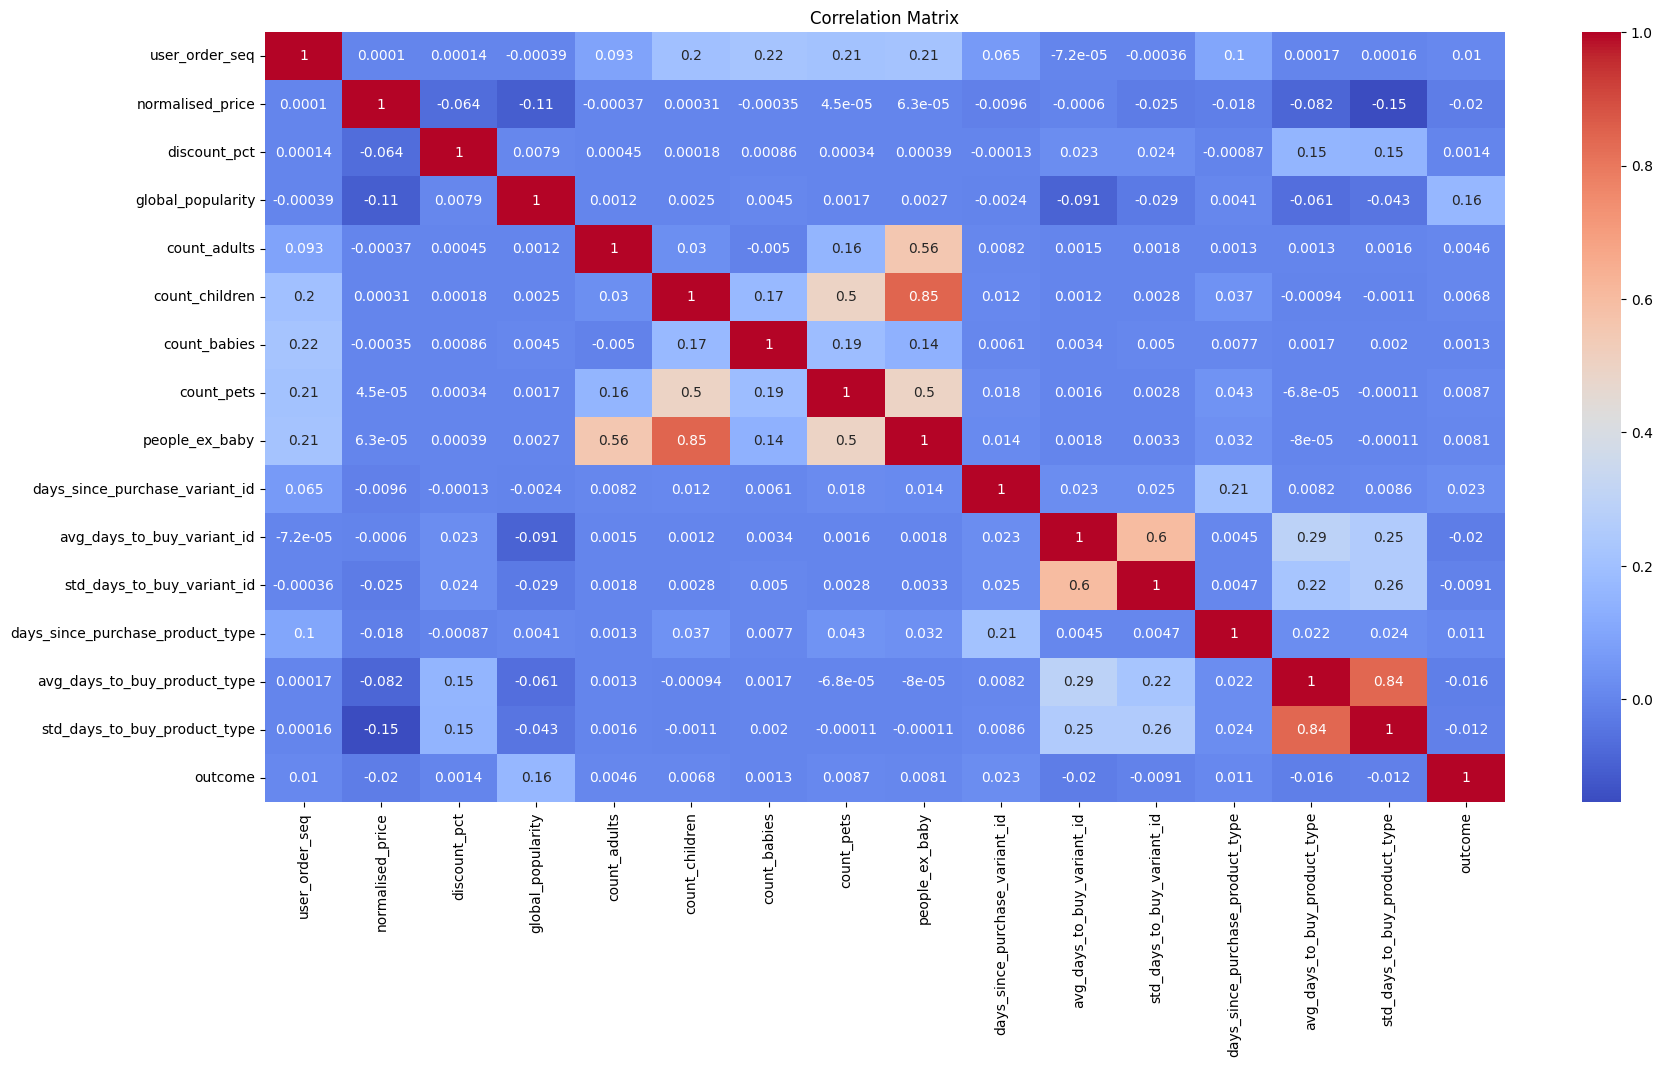

In [116]:
# Correlation betweeen outcome and numerical features
correlation = feature_frame[numerical_cols + [target]].corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

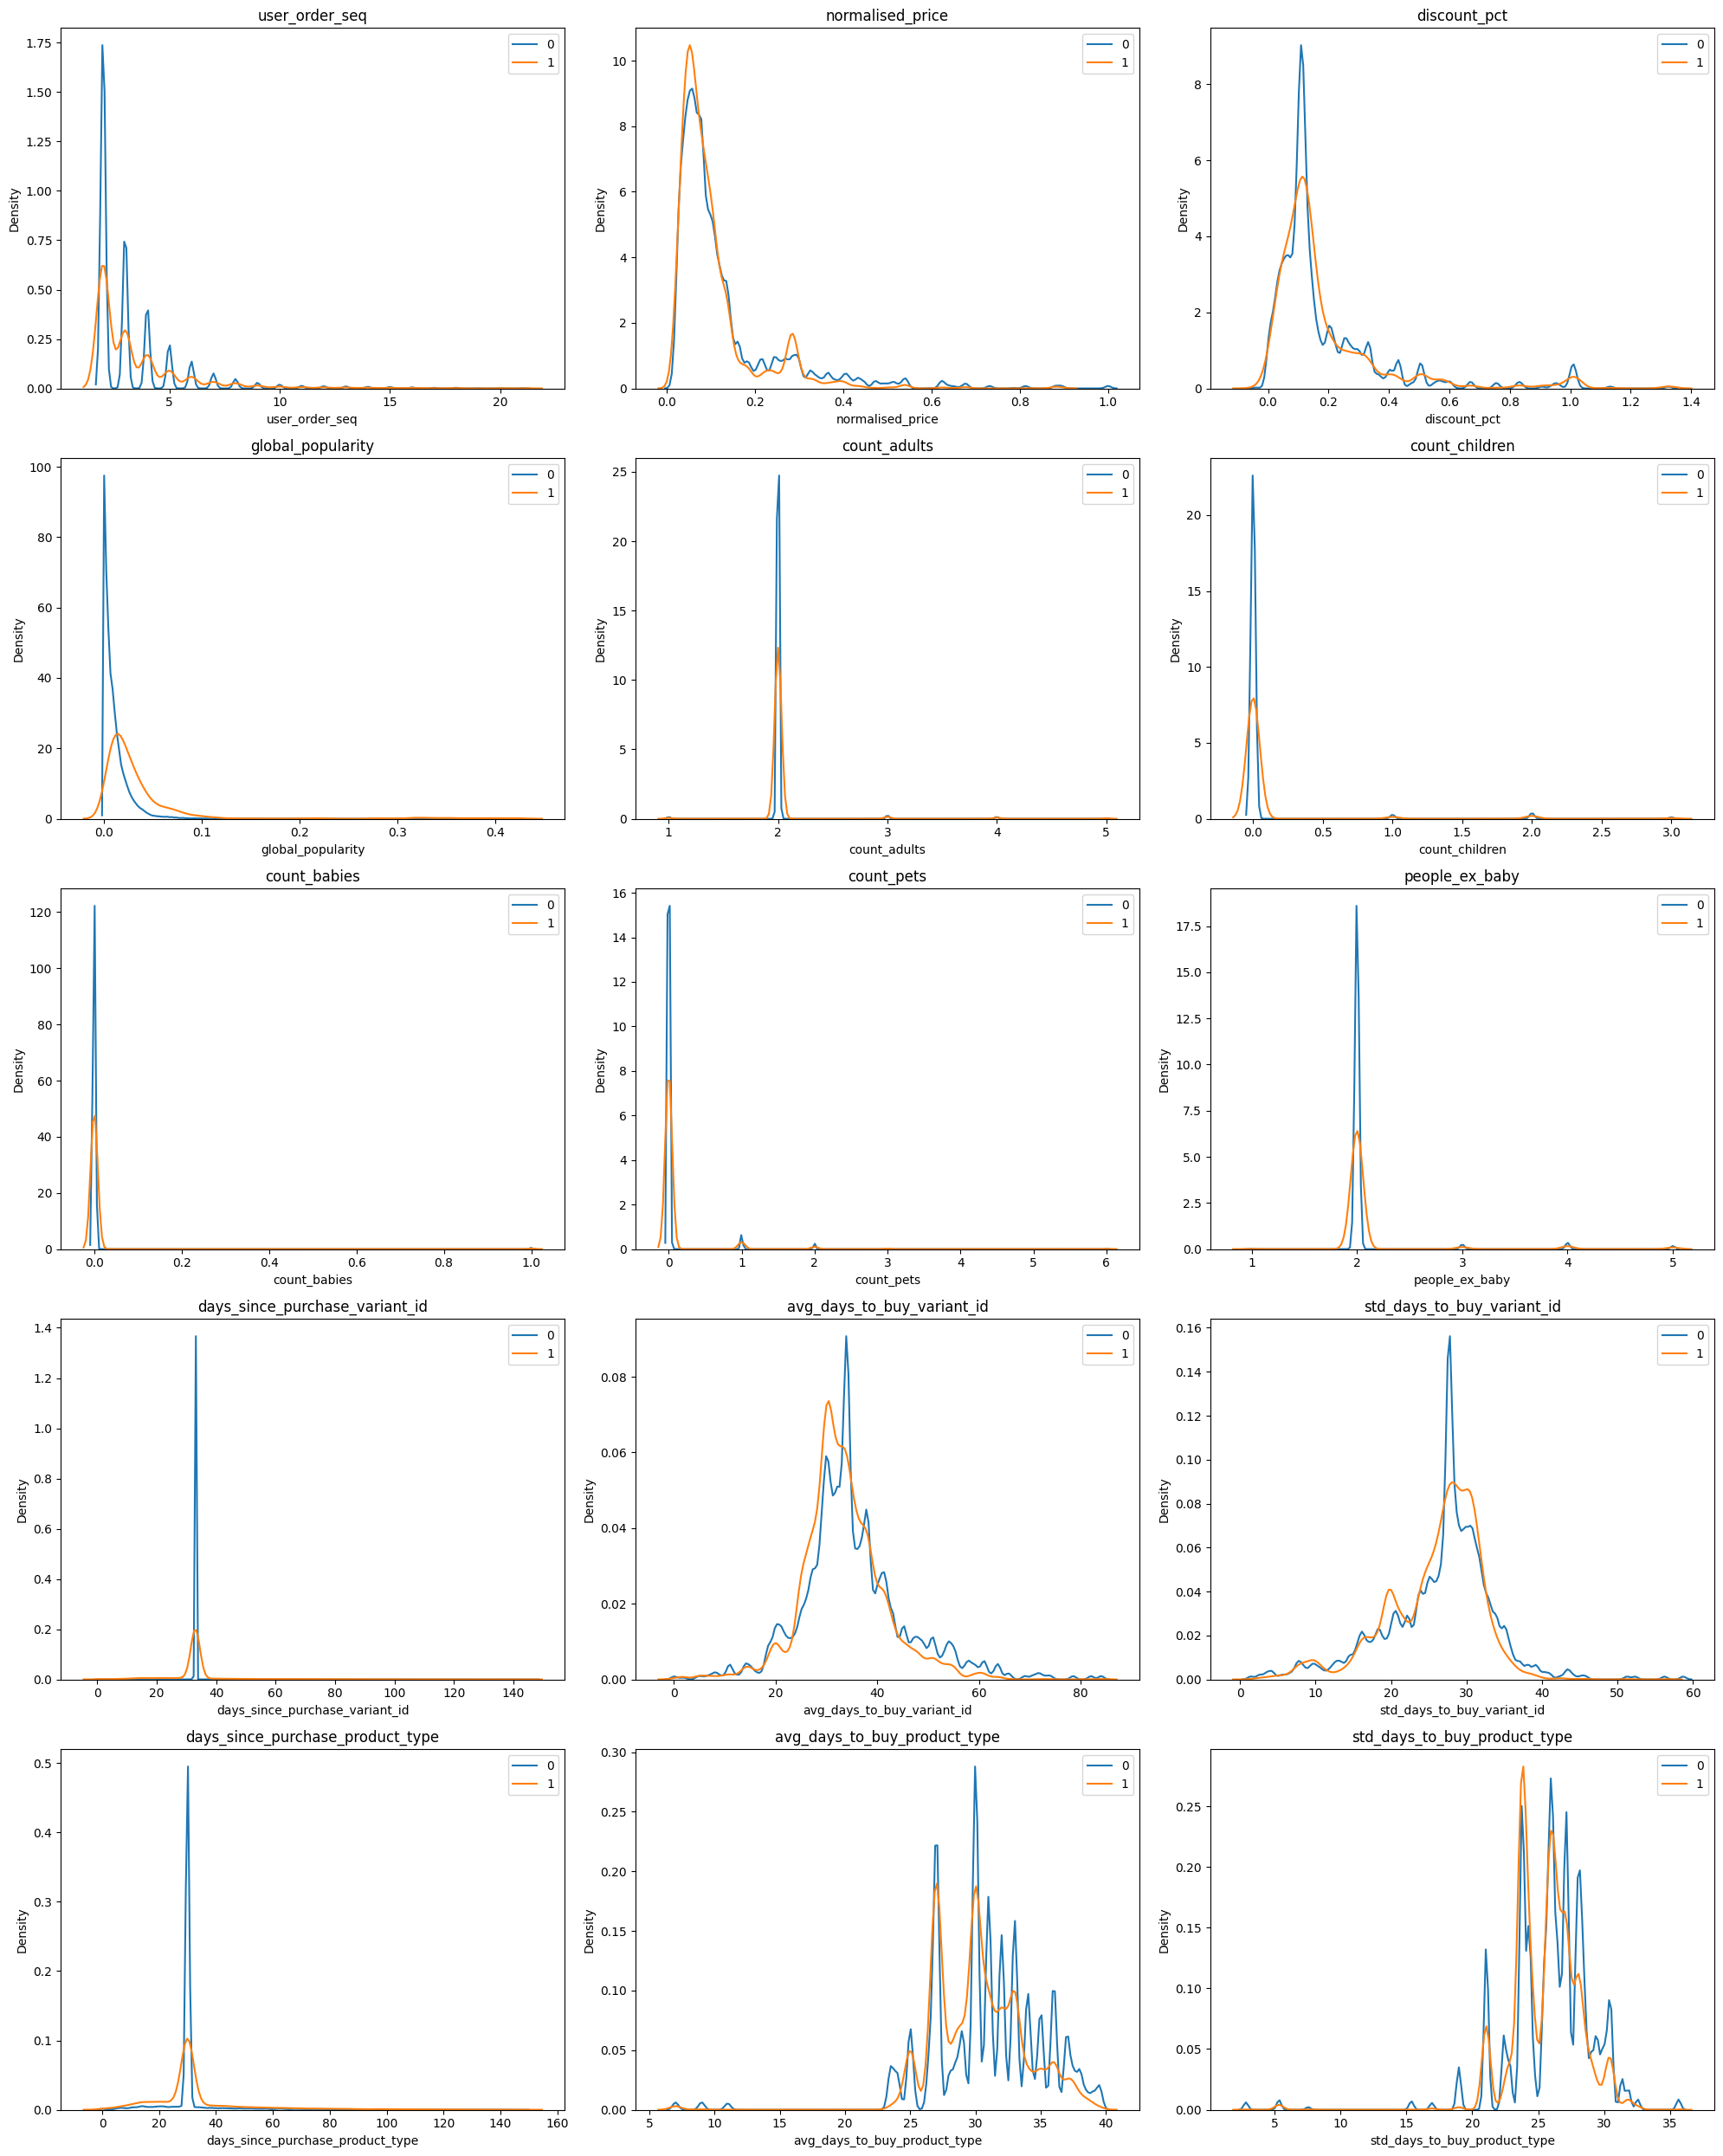

In [127]:
# Distribution of numerical features by outcome
rows = int(np.ceil(len(numerical_cols) / 3))
fig, ax = plt.subplots(rows, 3, figsize=(20, 5 * rows))
ax = ax.flatten()
for i, col in enumerate(numerical_cols):
    sns.kdeplot(feature_frame.loc[lambda x: x[target] == 0, col], label="Class 0", ax=ax[i])
    sns.kdeplot(feature_frame.loc[lambda x: x[target] == 1, col], label="Class 1", ax=ax[i])
    ax[i].set_title(col)
    ax[i].legend()

plt.tight_layout()

In [128]:
feature_frame[categorical_cols].describe()

,product_type,vendor
count,2880549,2880549
unique,62,264
top,tinspackagedfoods,biona
freq,226474,146828


Insights:
- There are 62 unique product_types and 264 brands, making the categorical encoding of these features a challenge, as it would create a large number of dummy variables in case of using one-hot encoding. Label or frecuencia encoding could be used instead.
- The majority of the products have not been ordered or abandoned before, are not snoozed, and have not been set as regulars. However, when they are set as regulars or abandoned before, there's a noticeable increase in the mean outcome.
- Regarding numerical variables, some of them have high spikes in the distribution, which most likely are the result of univariate imputations: mean,median,etc.
- There are multiple corralated features, so we should be careful when using them in a model, specially if we are using a regression model.

